In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from ipywidgets import fixed, interact_manual
import scipy.signal
import cv2
%matplotlib inline

# Fourier transform
## high level idea
![img1.png](src/img1.png)

Surprisingly the combination of simple cosine/sine signals can give rise to very complicated signal. With Fourier transform, for any given signal, we can decompose it to simple componenets. 
For example, $$f(x) = cos(x) + 1/2cos(2x) + 1/3cos(3x)$$
![image.png](src/img2.png)

We can see the complicated signal on the left hand side can be decomposed to a combination of 1Hz, 2Hz and 3Hz signal. We can use (1, 1/2, 1/3) to represent the signal. This is called **frequency domain** representation. 
![image.png](src/img3.png)

Genernally, we can do this to any signal besides the example above. 
In summary, **Fourier transform** converts a signal in the time domain to the frequency domain. We also have the **inverse Fourier transform** that converts a signal in the frequency domain back to the time domain. 
![image.png](src/rtaImage.png)

In [2]:
def signal_plot( signal_freq):
    num_samples = 1000
    sampling_points = np.linspace(0, 2 * np.pi * signal_freq, num_samples)
    cos_values = np.cos(signal_freq * sampling_points)
    plt.figure()
    plt.plot(sampling_points, cos_values)
    plt.show()
interact_manual(signal_plot, signal_freq=(0, 10.0))

interactive(children=(FloatSlider(value=5.0, description='signal_freq', max=10.0), Button(description='Run Int…

<function __main__.signal_plot(signal_freq)>

## Fourier transform on Image

For images, we have a 2D discrete version of Fourier transform for it, too. 
![image.png](src/img4.png)
The corresponding frequency domain representation of the image is not a 1D histogram anymore. It becomes 2D as well. 
![2d_fft](src/2d_fft.png)
We can compute the maginitude $\sqrt{x^2 + y^2}$ as a new representation:
![image.png](src/img5.png)

In the frequency domain representation, magnitude of low frequencies are near the center. We can see that low frequency signals are the majority. We can keep only the low frequency part and high frequency part of the signal with **low pass** and **high pass** filter. With inverse Fourier transform we can translate signal in the frequence domain back to the time domain. We can see that low frequence part corresponds the blurred part of the image and high frequence part corresponds to details of the image. 
![image.png](src/img6.png)

In [2]:
# discrete Fourier transform
def DFT(img):
    return fftshift(fft2(img))


# take the maginitude of the result of DFT and convert it to log scale
def scale_spectrum(dft):
    mag = np.abs(dft)
    return np.log10(mag + 1)


# inverse discrete Fourier transform
def IDFT(dft):
    return ifft2(ifftshift(dft))

# generate Gaussian kernel
def Gaussian_kernel(size, sigma):
    gaussian_1d = scipy.signal.gaussian(size, sigma)
    return np.outer(gaussian_1d , gaussian_1d)

# helper display function
def show_DFT(dft):
    plt.imshow(scale_spectrum(dft), cmap='gray')

# low pass filter    
def low_pass(dft, sigma=15):
    size = dft.shape[0]
    gaussian = Gaussian_kernel(size, sigma)
    weight = gaussian
    return dft * weight

# high pass filter 
def high_pass(dft, sigma=15):
    size = dft.shape[0]
    gaussian = Gaussian_kernel(size, sigma)
    weight = (1 - gaussian)
    return dft * weight

In [7]:
img = np.array(Image.open('img/classical/einstein.jpg').convert('L'))
dft = DFT(img)

In [5]:
def image_dft_plot(radius):
    fig, ax = plt.subplots(1, 5, figsize=(20,20))
    np.vectorize(lambda ax:ax.axis('off'))(ax)
    ax[0].imshow(img,  cmap='gray')
    ax[0].set_title('original image')
    mask = np.ones(img.shape)
    radius = max(1, radius)
    radius = min(radius, min(mask.shape[0]//2-1, mask.shape[1]//2-1))
    mask = cv2.circle(mask, (mask.shape[0]//2, mask.shape[1]//2), radius, (0,0,0), -1)
    ax[1].imshow(scale_spectrum(dft * mask), cmap='gray')
    ax[1].set_title('low frequency component')
    ax[2].imshow(IDFT(dft * mask).real, cmap='gray')
    ax[2].set_title('inverse Fourier transform result')
    ax[3].imshow(scale_spectrum(dft * (1-mask)), cmap='gray')
    ax[3].set_title('high frequency component')
    ax[4].imshow(IDFT(dft * (1-mask)).real, cmap='gray')
    ax[4].set_title('inverse Fourier transform result')
    plt.show()
interact_manual(image_dft_plot, radius=(0,100))

interactive(children=(IntSlider(value=50, description='radius'), Button(description='Run Interact', style=Butt…

<function __main__.image_dft_plot(radius)>

In [8]:
def image_dft_plot2(x1, x2):
    fig, ax = plt.subplots(1, 5, figsize=(20,20))
    np.vectorize(lambda ax:ax.axis('off'))(ax)
    ax[0].imshow(img,  cmap='gray')
    ax[0].set_title('original image')
    mask = np.ones(img.shape)
    mask1 = cv2.fillPoly(mask.copy(), [np.array([(mask.shape[0]//2, mask.shape[1]//2), 
                                             (mask.shape[0]//2-x1, 0), 
                                             (mask.shape[0]//2+x2, 0),
                                             (mask.shape[0]//2-x2, mask.shape[0]-1),
                                             (mask.shape[0]//2+x1, mask.shape[0]-1),
                                            ],dtype=np.int32)], (0,0,0))

    mask2 = cv2.fillPoly(mask.copy(), [np.array([(mask.shape[0]//2, mask.shape[1]//2), 
                                             (0, mask.shape[1]//2-x1), 
                                             (0, mask.shape[1]//2+x2),
                                             (mask.shape[1]-1, mask.shape[1]//2-x2),
                                             (mask.shape[1]-1, mask.shape[1]//2+x1),
                                            ],dtype=np.int32)], (0,0,0))
    ax[1].imshow(scale_spectrum(dft * mask1), cmap='gray')
    ax[1].set_title('filtered DFT')
    ax[2].imshow(IDFT(dft * mask1).real, cmap='gray')
    ax[2].set_title('inverse Fourier transform result')
    ax[3].imshow(scale_spectrum(dft * mask2), cmap='gray')
    ax[3].set_title('filtered DFT')
    ax[4].imshow(IDFT(dft * mask2).real, cmap='gray')
    ax[4].set_title('inverse Fourier transform result')
    plt.show()
interact_manual(image_dft_plot2, x1=(0,100), x2=(0,100))

interactive(children=(IntSlider(value=50, description='x1'), IntSlider(value=50, description='x2'), Button(des…

<function __main__.image_dft_plot2(x1, x2)>

We can play around with Einstein's picture and examine its low frequency part and high frequency part.

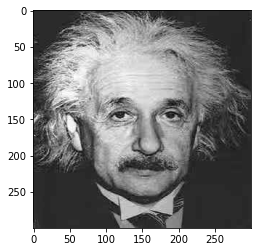

In [9]:
# load the grayscale image of Einstein
img = np.array(Image.open('img/classical/einstein.jpg').convert('L'))
plt.imshow(img, cmap="gray")

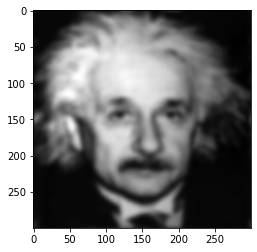

In [18]:
# perform Fourier transform
dft = DFT(img)
# apply low pass filter to get low frequency part
low = low_pass(dft)
# convert back to time domain
img_low = IDFT(low).real

plt.imshow(img_low, cmap='gray')

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


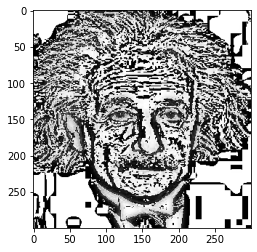

In [16]:
kernel = cv2.getGaussianKernel(5, 0) * cv2.getGaussianKernel(5,0).T
print(kernel)
img_g = cv2.GaussianBlur(img, (25,25), 0)
residue = img - img_g
plt.imshow(residue, cmap="gray_r")

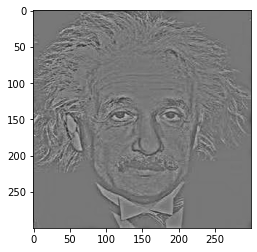

In [17]:
# apply high pass filter to get high frequency part
high = high_pass(dft) # notice because we use log scale for display, the center of high frequency data is not a black hole, but dft = low + high actually holds
# convert back to time domain
img_high = IDFT(high).real
plt.imshow(img_high, cmap='gray')

## Hybrid image
The idea of hybrid image is to mixing two images in the frequency domain. Here are the steps to do it:

1. convert two images to frequency domain with DFT
2. get the low frequency component of one image and the high frequency component of another image
3. convert the signals from the frequency domain back to time domain
4. mix the low frequency component of one image with the high frequency component of another image in time domain


In [3]:
def hybrid_image(img1, img2):
    # convert images to frequency domain
    dft1 = DFT(img1)
    dft2 = DFT(img2)
    # get the low frequency component and the high frequency component of two images
    low1 = low_pass(dft1)
    high2 = high_pass(dft2)
    # convert back to time domain
    img1_low = IDFT(low1)
    img2_high = IDFT(high2)
    # mix components by adding them together
    hybrid_img = img1_low + img2_high
    # keep only the real part of the result
    return np.real(hybrid_img)

## Fun with Hybrid Image
Next, we are going the create a hybrid image with low frequency component from Albert Einstein and high frequency component from Marilyn Monroe.

When we directly look at the hybrid image, high frequency component dominates so we see the face of Marilyn Monroe. If we step back and watch the image at a distance, since zooming out acts as a low pass filter and blurs the image, we see the face of Albert Einstein instead.

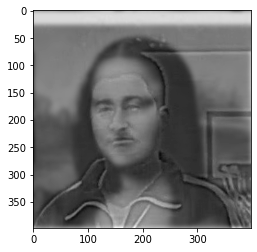

In [4]:
# img1 = np.array(Image.open('img/classical/einstein.jpg').convert('L')) 
# img2 = np.array(Image.open('img/classical/marilynn.jpg').convert('L'))

# img1 = np.array(Image.open('img/pet/dog.jpg').convert('L')) 
# img2 = np.array(Image.open('img/pet/cat.jpg').convert('L'))

img1 = np.array(Image.open('img/1.jpg').convert('L')) 
img2 = np.array(Image.open('img/2.jpg').convert('L'))


hybrid = hybrid_image(img1, img2)
plt.imshow(hybrid, cmap='gray')